In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_pull_request.parquet")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932791 entries, 0 to 932790
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          932791 non-null  int64  
 1   number      932791 non-null  int64  
 2   title       932790 non-null  object 
 3   body        924018 non-null  object 
 4   agent       932791 non-null  object 
 5   user_id     932791 non-null  int64  
 6   user        932791 non-null  object 
 7   state       932791 non-null  object 
 8   created_at  932791 non-null  object 
 9   closed_at   859927 non-null  object 
 10  merged_at   790139 non-null  object 
 11  repo_id     930292 non-null  float64
 12  repo_url    932791 non-null  object 
 13  html_url    932791 non-null  object 
dtypes: float64(1), int64(3), object(10)
memory usage: 99.6+ MB


In [8]:
# Convertir fechas
date_cols = ["created_at", "closed_at", "merged_at"]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

# Crear columna binaria: ¿PR generado por agente?
df["is_agent"] = df["agent"].notna() & (df["agent"] != "")
df["is_agent"] = df["is_agent"].astype(int)

# Ver resumen
df[["agent", "is_agent"]].head()


,agent,is_agent
0,Claude_Code,1
1,Claude_Code,1
2,Claude_Code,1
3,Claude_Code,1
4,Claude_Code,1


In [9]:
print("Total PRs:", len(df))
print("Total usuarios:", df['user_id'].nunique())
print("Total repos:", df['repo_id'].nunique())

df.describe(include="all")


Total PRs: 932791
Total usuarios: 72189
Total repos: 116211


,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url,is_agent
count,9.327910e+05,932791.000000,932790,924018,932791,9.327910e+05,932791,932791,932791,859927,790139,9.302920e+05,932791,932791,932791.0
unique,NaN,NaN,870963,918646,5,NaN,72189,2,NaN,NaN,NaN,NaN,116423,932791,NaN
top,NaN,NaN,Add MIT license,This pull request contains changes generated b...,OpenAI_Codex,NaN,Copilot,closed,NaN,NaN,NaN,NaN,https://api.github.com/repos/mochilang/mochi,https://github.com/Metta-AI/metta/pull/1688,NaN
freq,NaN,NaN,1039,1974,814522,NaN,49842,859927,NaN,NaN,NaN,NaN,8913,1,NaN
mean,3.173861e+09,402.430068,NaN,NaN,NaN,9.978203e+07,NaN,NaN,2025-06-24 07:42:43.873036032+00:00,2025-06-24 09:58:23.498194176+00:00,2025-06-25 00:34:19.778819072+00:00,9.320231e+08,NaN,NaN,1.0
min,2.756922e+09,1.000000,NaN,NaN,NaN,1.700000e+01,NaN,NaN,2024-12-24 00:23:09+00:00,2024-12-24 01:46:49+00:00,2024-12-24 01:46:48+00:00,2.727000e+03,NaN,NaN,1.0
25%,3.131060e+09,6.000000,NaN,NaN,NaN,2.073098e+07,NaN,NaN,2025-06-09 18:11:02+00:00,2025-06-10 00:05:48.500000+00:00,2025-06-10 08:39:05.500000+00:00,9.681841e+08,NaN,NaN,1.0
50%,3.172264e+09,29.000000,NaN,NaN,NaN,8.937460e+07,NaN,NaN,2025-06-24 14:38:43+00:00,2025-06-24 18:22:28+00:00,2025-06-24 19:31:14+00:00,9.963319e+08,NaN,NaN,1.0
75%,3.225226e+09,128.000000,NaN,NaN,NaN,1.802315e+08,NaN,NaN,2025-07-12 11:20:17.500000+00:00,2025-07-12 10:41:07+00:00,2025-07-12 12:59:14+00:00,1.006862e+09,NaN,NaN,1.0
max,3.278268e+09,258447.000000,NaN,NaN,NaN,2.237354e+08,NaN,NaN,2025-07-30 19:50:49+00:00,2025-07-30 23:20:55+00:00,2025-07-30 23:20:55+00:00,1.029817e+09,NaN,NaN,1.0


In [10]:
global_agent_ratio = df["is_agent"].mean()
print(f"Proporción global de PRs generados por agentes: {global_agent_ratio:.2%}")


Proporción global de PRs generados por agentes: 100.00%


In [11]:
user_stats = df.groupby("user_id").agg(
    total_prs=("id", "count"),
    agent_prs=("is_agent", "sum"),
    repo_count=("repo_id", pd.Series.nunique),
    first_activity=("created_at", "min"),
    last_activity=("created_at", "max"),
    merge_rate=("merged_at", lambda x: x.notna().mean())
)

user_stats["agent_ratio"] = user_stats["agent_prs"] / user_stats["total_prs"]
user_stats["active_days"] = (user_stats["last_activity"] - user_stats["first_activity"]).dt.days
user_stats.head()


,total_prs,agent_prs,repo_count,first_activity,last_activity,merge_rate,agent_ratio,active_days
user_id,,,,,,,,
17,7,7,3,2025-05-24 02:33:06+00:00,2025-06-24 03:05:27+00:00,0.428571,1.0,31
19,2,2,2,2025-05-20 00:36:30+00:00,2025-05-21 00:13:00+00:00,0.500000,1.0,0
27,8,8,1,2025-05-19 09:22:29+00:00,2025-07-03 02:45:13+00:00,0.500000,1.0,44
70,1,1,1,2025-06-02 08:12:57+00:00,2025-06-02 08:12:57+00:00,0.000000,1.0,0
93,1,1,1,2025-05-30 17:20:22+00:00,2025-05-30 17:20:22+00:00,0.000000,1.0,0


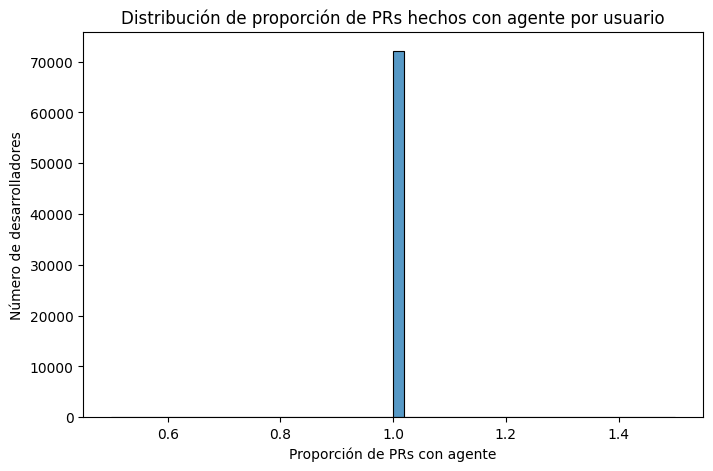

In [12]:
plt.figure(figsize=(8,5))
sns.histplot(user_stats["agent_ratio"], bins=50)
plt.title("Distribución de proporción de PRs hechos con agente por usuario")
plt.xlabel("Proporción de PRs con agente")
plt.ylabel("Número de desarrolladores")
plt.show()


In [13]:
users_agent = user_stats[user_stats["agent_prs"] > 0]
users_nonagent = user_stats[user_stats["agent_prs"] == 0]

comparison = pd.DataFrame({
    "mean_total_prs": [
        users_agent["total_prs"].mean(),
        users_nonagent["total_prs"].mean()
    ],
    "mean_repo_count": [
        users_agent["repo_count"].mean(),
        users_nonagent["repo_count"].mean()
    ],
    "mean_merge_rate": [
        users_agent["merge_rate"].mean(),
        users_nonagent["merge_rate"].mean()
    ],
    "active_days": [
        users_agent["active_days"].mean(),
        users_nonagent["active_days"].mean()
    ],
}, index=["Usuarios con agente", "Usuarios sin agente"])

comparison


,mean_total_prs,mean_repo_count,mean_merge_rate,active_days
Usuarios con agente,12.921512,1.649268,0.649552,5.64985
Usuarios sin agente,NaN,NaN,NaN,NaN


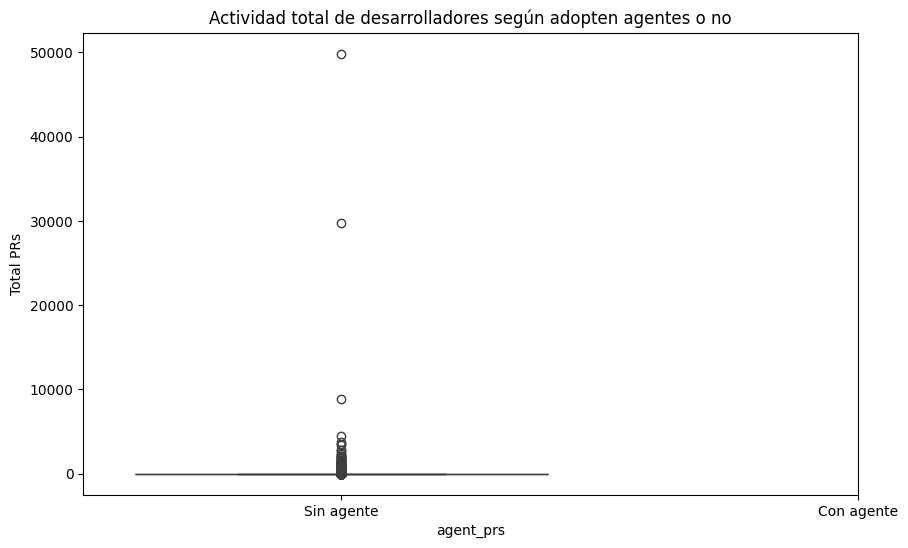

In [14]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=user_stats,
    x=(user_stats["agent_prs"] > 0),
    y="total_prs"
)
plt.xticks([0,1], ["Sin agente", "Con agente"])
plt.title("Actividad total de desarrolladores según adopten agentes o no")
plt.ylabel("Total PRs")
plt.show()


2

In [15]:
repo_stats = df.groupby("repo_id").agg(
    total_prs=("id", "count"),
    agent_prs=("is_agent", "sum"),
    first_pr=("created_at", "min"),
    last_pr=("created_at", "max"),
    unique_users=("user_id", pd.Series.nunique)
)

repo_stats["agent_ratio"] = repo_stats["agent_prs"] / repo_stats["total_prs"]
repo_stats["active_days"] = (repo_stats["last_pr"] - repo_stats["first_pr"]).dt.days

repo_stats.head()


,total_prs,agent_prs,first_pr,last_pr,unique_users,agent_ratio,active_days
repo_id,,,,,,,
2727.0,1,1,2025-07-10 18:20:17+00:00,2025-07-10 18:20:17+00:00,1,1.0,0
3542.0,1,1,2025-07-23 13:32:35+00:00,2025-07-23 13:32:35+00:00,1,1.0,0
6675.0,3,3,2025-07-16 16:34:07+00:00,2025-07-16 16:38:23+00:00,1,1.0,0
33509.0,4,4,2025-06-04 09:05:13+00:00,2025-06-05 23:48:16+00:00,1,1.0,1
37370.0,1,1,2025-06-22 10:40:17+00:00,2025-06-22 10:40:17+00:00,1,1.0,0


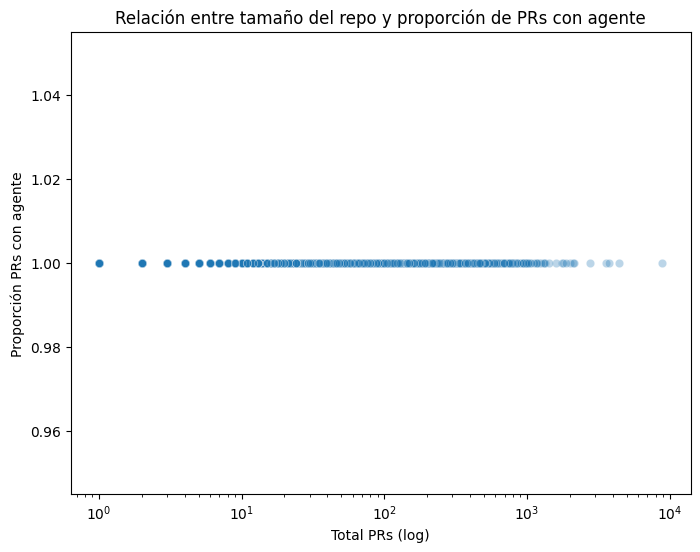

In [16]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=repo_stats,
    x="total_prs",
    y="agent_ratio",
    alpha=0.3
)
plt.xscale("log")
plt.title("Relación entre tamaño del repo y proporción de PRs con agente")
plt.xlabel("Total PRs (log)")
plt.ylabel("Proporción PRs con agente")
plt.show()


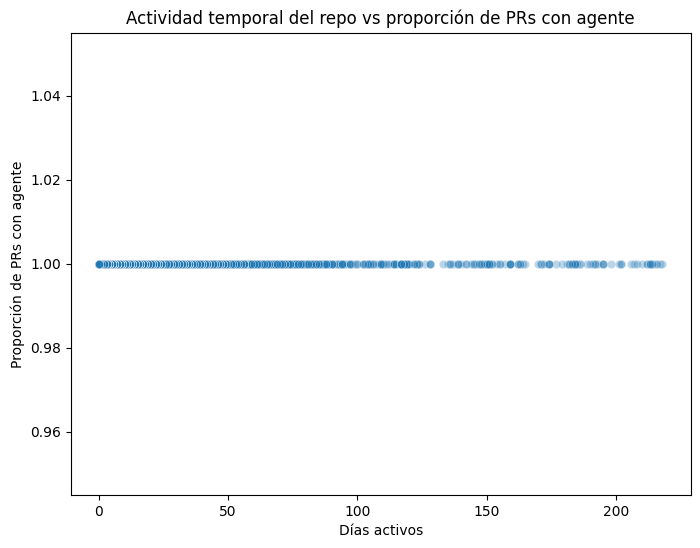

In [17]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=repo_stats,
    x="active_days",
    y="agent_ratio",
    alpha=0.3
)
plt.title("Actividad temporal del repo vs proporción de PRs con agente")
plt.xlabel("Días activos")
plt.ylabel("Proporción de PRs con agente")
plt.show()


In [18]:
repo_stats[["total_prs", "unique_users", "active_days", "agent_ratio"]].corr()


,total_prs,unique_users,active_days,agent_ratio
total_prs,1.000000,0.039261,0.237730,NaN
unique_users,0.039261,1.000000,0.266348,NaN
active_days,0.237730,0.266348,1.000000,NaN
agent_ratio,NaN,NaN,NaN,NaN


In [19]:
import statsmodels.api as sm

X = repo_stats[["total_prs", "unique_users", "active_days"]].fillna(0)
X = np.log1p(X)  # Escalado logarítmico
y = repo_stats["agent_ratio"].fillna(0)

model = sm.OLS(y, sm.add_constant(X)).fit()
model.summary()


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            agent_ratio   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                -3.874e+04
Date:                Tue, 18 Nov 2025   Prob (F-statistic):               1.00
Time:                        18:50:15   Log-Likelihood:             3.7368e+06
No. Observations:              116211   AIC:                        -7.474e+06
Df Residuals:                  116207   BIC:                        -7.473e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.0000   8.37e-17   1.19e+16      0.000       1.000       1.000
total_prs    -9.984e-17   1.08e-17     -9.230      0.000   -1.21e-16   -7.86e-17
unique_users  6.159e-15   1.19e-16     51.919      0.000    5.93e-15    6.39e-15
active_days   9.368e-16   9.48e-18     98.803      0.000    9.18e-16    9.55e-16
==============================================================================
Omnibus:                    67815.523   Durbin-Watson:                   0.372
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           658008.273
Skew:                          -2.706   Prob(JB):                         0.00
Kurtosis:                      13.325   Cond. No.                         40.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""